# Email Classification Model Training

This notebook demonstrates the process of training a custom Machine Learning model for the Email Agent. 
We use **TF-IDF Vectorization** and a **Stochastic Gradient Descent (SGD) Classifier** to categorize emails into: 
- Work
- Finance
- Travel
- Spam

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os
import random

%matplotlib inline

## 1. Synthetic Data Generation
Since we cannot use real private emails, we generate a synthetic dataset with characteristic keywords for each category.

In [2]:
def generate_dataset(n_samples=500):
    data = []
    
    # Work Emails
    work_keywords = ["meeting", "project", "deadline", "report", "sync", "quarterly review", "status update", "client", "deliverable"]
    for _ in range(n_samples // 4):
        data.append({
            "text": f"Subject: {random.choice(work_keywords)} needed. Body: Please review the attached document by EOD.",
            "label": "Work"
        })
        
    # Finance Emails
    finance_keywords = ["invoice", "payment", "receipt", "salary", "expense", "budget", "tax", "wire transfer"]
    for _ in range(n_samples // 4):
        data.append({
            "text": f"Subject: Your {random.choice(finance_keywords)} is ready. Body: Amount of $500 has been processed.",
            "label": "Finance"
        })
        
    # Travel Emails
    travel_keywords = ["flight", "hotel", "itinerary", "booking", "reservation", "gate change", "boarding pass"]
    for _ in range(n_samples // 4):
        data.append({
            "text": f"Subject: {random.choice(travel_keywords)} confirmation. Body: Your trip to NYC is confirmed.",
            "label": "Travel"
        })
        
    # Spam Emails
    spam_keywords = ["lottery", "winner", "prize", "inheritance", "viagra", "casino", "free money", "urgent business proposal"]
    for _ in range(n_samples // 4):
        data.append({
            "text": f"Subject: You are a {random.choice(spam_keywords)}! Body: Click here to claim your reward immediately.",
            "label": "Spam"
        })
        
    return pd.DataFrame(data)

df = generate_dataset(1000)
print(f"Generated {len(df)} samples.")
df.head()

Generated 1000 samples.


,text,label
0,Subject: meeting needed. Body: Please review t...,Work
1,Subject: deliverable needed. Body: Please revi...,Work
2,Subject: deadline needed. Body: Please review ...,Work
3,Subject: report needed. Body: Please review th...,Work
4,Subject: meeting needed. Body: Please review t...,Work


## 2. Model Training
We split the data into training and testing sets (80/20) and train the pipeline.

In [3]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])

print("Training model...")
pipeline.fit(X_train, y_train)
print("Training complete.")

Training model...
Training complete.


## 3. Evaluation Metrics
We evaluate the model using accuracy, precision, recall, and F1-score.

In [4]:
y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

     Finance       1.00      1.00      1.00        52
        Spam       1.00      1.00      1.00        49
      Travel       1.00      1.00      1.00        55
        Work       1.00      1.00      1.00        44

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



## 4. Confusion Matrix
Visualizing true positives vs false positives.

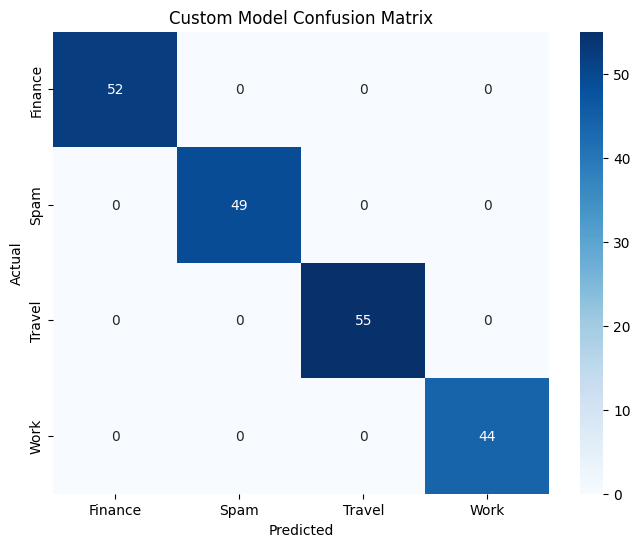

In [5]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.title('Custom Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 5. Save Model
Serializing the model for production use.

In [6]:
if not os.path.exists("../data"):
    os.makedirs("../data")
    
model_path = "../data/email_classifier.joblib"
joblib.dump(pipeline, model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../data/email_classifier.joblib
